In [2]:
# imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [6]:
df = pd.read_csv('OPEC_annual_prices', delimiter='\t', header=0) 

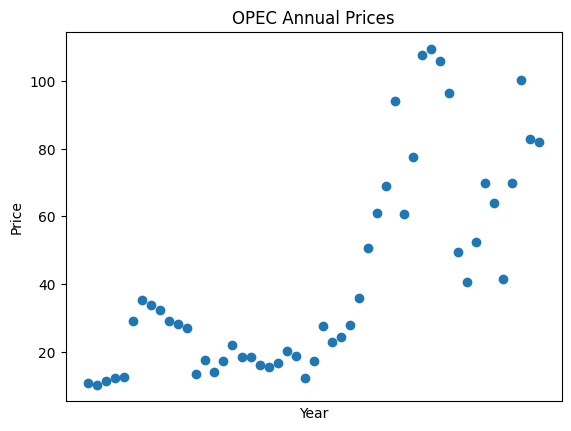

In [3]:
# plot data
plt.scatter(df['Year'], df['Price'])
plt.xticks([]) # remove x ticks 
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('OPEC Annual Prices')
plt.show()

Some things to observe about this data...
1. x-values are in years, so they are quite big. I could rescale them if I want to do something with a polynomial. 
2. The y-values are between 10 and 100. There is a lot of fluctuation later on, so it is possible that I need a model that can move around a bit. 

In [ ]:
X = df['Year'].values.astype(np.float32)
# scale from 0 to 1
X = (X - X.min()) / (X.max() - X.min())
y = df['Price'].values.astype(np.float32)

# split the data into training and testing data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=13)


Based on what I am seeing, let's say I pick an exponential model $y = ae^{bx} + c$ to capture this small amount in the beginning and a large amount in more recent years. There are honestly a LOT of good model types to pick. 

I will pick my error to be mean absolute error. $$E=  \frac{1}{n} \sum_{i=1}^n\left |y_i-\hat y_i \right |$$

Let's pick some initial parameters by guessing and checking with the data. 

In [5]:
def f(a:float, b:float, c:float, set:np.ndarray) -> float:
    """Defines the exponential function"""
    return a * np.exp(set*b) + c

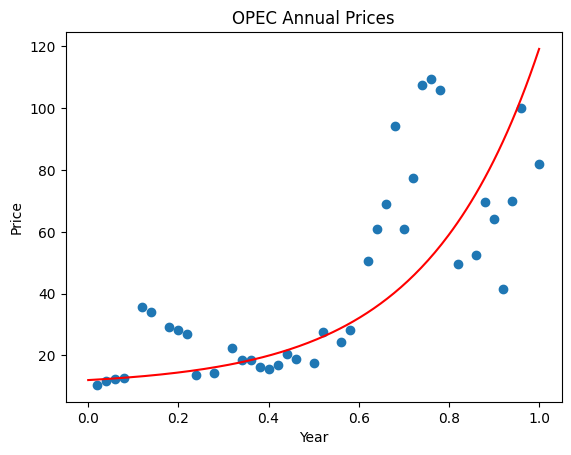

In [6]:
# initial parameters 
a = 2
b = 4
c = 10

# plot data and model 
x = np.linspace(0, 1, 200)
y = f(a, b, c, x)
plt.plot(x, y, 'r')
plt.scatter(X_train, y_train)
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('OPEC Annual Prices')
plt.show()

That looks pretty good. Now let's perform gradient descent and figure out our hyperparameters for the model using our validation set. 

In [7]:
def error(a:float, b:float, c:float, X:np.ndarray, y:np.ndarray) -> float:
    """Defines the loss function"""
    return np.mean((np.abs(f(a, b, c, X) - y)))

In [12]:
# Hyperparameters
learning_rate = 1E-4
epochs = 2000

# initial parameters 
a = 2
b = 4
c = 10

# Number of samples
n = len(X_train)

# Epoch data 
trainig_losses = []
validation_losses = []

# Training loop
for epoch in range(epochs):
    
    y_pred_train = f(a, b, c, X_train)
    residuals = y_pred_train - y_train

    # Compute derivatives
    da = 1/n * np.sum(np.sign(residuals) * np.exp(X_train*b))
    db = 1/n * np.sum(np.sign(residuals * X_train))
    dc = 1/n * np.sum(np.sign(residuals))

    # Update parameters
    a = a - learning_rate * da
    b = b - learning_rate * db
    c = c - learning_rate * dc

    # Compute training loss
    training_loss = error(a, b, c, X_train, y_train)
    trainig_losses.append(training_loss)

    # Compute validation loss
    loss_val = error(a, b, c, X_val, y_val)
    validation_losses.append(loss_val)

    # Print progress every n epochs
    n = 250
    if epoch % n == 0:
        print(f'Epoch: {epoch}, Loss: {training_loss}, Validation Loss: {loss_val}, a: {a}, b: {b}, c: {c}')

# Print final loss and parameters
print(f'Final Training Loss: {error(a, b, c, X_train, y_train)}')
print(f'Final Validation Loss: {error(a, b, c, X_val, y_val)}')
print(f'a: {a}, b: {b}, c: {c}')



Epoch: 0, Loss: 16.130199432373047, Validation Loss: 15.384414672851562, a: 1.9994971604919434, b: 3.99999, c: 9.99999
Epoch: 250, Loss: 16.035411834716797, Validation Loss: 15.472805976867676, a: 1.9802298872131354, b: 3.999789999999994, c: 9.999789999999884
Epoch: 500, Loss: 15.942021369934082, Validation Loss: 15.560376167297363, a: 1.9610436800109894, b: 3.99965079999999, c: 9.999650799999802
Epoch: 750, Loss: 15.851692199707031, Validation Loss: 15.646158218383789, a: 1.9420353914367823, b: 3.99965079999999, c: 9.999650799999802
Epoch: 1000, Loss: 15.810483932495117, Validation Loss: 15.700546264648438, a: 1.9297611673736754, b: 3.9997955999999943, c: 9.999795599999887
Epoch: 1250, Loss: 15.787951469421387, Validation Loss: 15.7429838180542, a: 1.9200522053314384, b: 3.9999956, c: 9.999995600000004
Epoch: 1500, Loss: 15.765401840209961, Validation Loss: 15.785449028015137, a: 1.9103410764892765, b: 4.0001955999998975, c: 10.00019560000012
Epoch: 1750, Loss: 15.742837905883789, Val

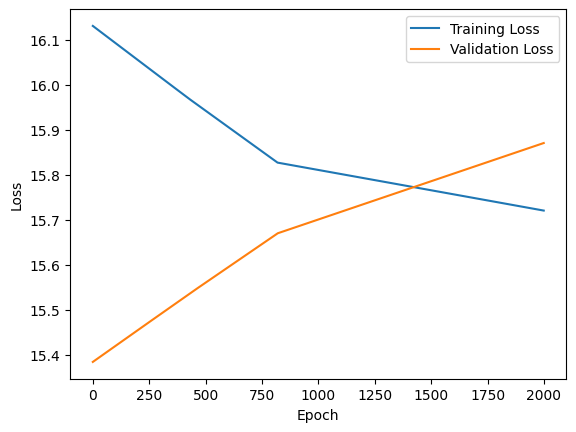

In [13]:
# Plot training and validation losses
plt.plot(trainig_losses, label='Training Loss') # plot every 5th value
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

The convergence isn't spectacular, but it looks like 1300 epochs is probably enough. I am happy with my learning rate, although I wish I did see a leveling off in the losses. From the graph, it looks like my average error is about $15. Given that prices are around $100, this seems like a tolerable error. 

Let's build our final model now. 

In [14]:
# Hyperparameters
learning_rate = 1E-4
epochs = 1300

# initial parameters 
a = 2
b = 4
c = 10

# Number of samples
n = len(X_train_val)

# Epoch data 
training_losses = []
test_losses = []

# Training loop
for epoch in range(epochs):
    
    y_pred_train = f(a, b, c, X_train_val)
    residuals = y_pred_train - y_train_val

    # Compute derivatives
    da = 1/n * np.sum(np.sign(residuals) * np.exp(X_train_val*b))
    db = 1/n * np.sum(np.sign(residuals * X_train_val))
    dc = 1/n * np.sum(np.sign(residuals))

    # Update parameters
    a = a - learning_rate * da
    b = b - learning_rate * db
    c = c - learning_rate * dc

    # Compute training loss
    training_loss = error(a, b, c, X_train_val, y_train_val)
    training_losses.append(training_loss)

    # Compute test loss
    loss_test = error(a, b, c, X_test, y_test)
    test_losses.append(loss_test)

    # Print progress every n epochs
    n = 250
    if epoch % n == 0:
        print(f'Epoch: {epoch}, Loss: {training_loss}, Test Loss: {loss_test}, a: {a}, b: {b}, c: {c}')

# Print final loss and parameters
print(f'Final Training Loss: {error(a, b, c, X_train_val, y_train_val)}')
print(f'Final Test Loss: {error(a, b, c, X_test, y_test)}')
print(f'a: {a}, b: {b}, c: {c}')

Epoch: 0, Loss: 16.04779815673828, Test Loss: 12.179509162902832, a: 1.9996031867133246, b: 3.9999977777777778, c: 9.999997777777779
Epoch: 250, Loss: 15.984272956848145, Test Loss: 11.974395751953125, a: 1.9825898636176216, b: 4.0000977777778335, c: 10.000097777777615
Epoch: 500, Loss: 15.9208984375, Test Loss: 11.7695951461792, a: 1.965586926544867, b: 4.000207377777887, c: 10.000207377777457
Epoch: 750, Loss: 15.86078929901123, Test Loss: 11.572012901306152, a: 1.9488222477545853, b: 4.00050737777784, c: 10.00050737777741
Epoch: 1000, Loss: 15.808472633361816, Test Loss: 11.392695426940918, a: 1.9335047924567343, b: 4.000838577777811, c: 10.000838577777381
Epoch: 1250, Loss: 15.798014640808105, Test Loss: 11.31295394897461, a: 1.9260416700293672, b: 4.001338577777881, c: 10.001338577777451
Final Training Loss: 15.795960426330566
Final Test Loss: 11.297308921813965
a: 1.9245783583594454, b: 4.001436577777895, c: 10.001436577777465


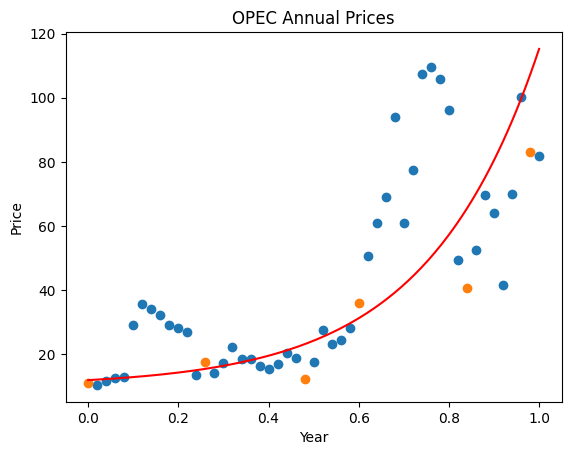

In [15]:
#plot our model with our data 
x = np.linspace(0, 1, 200)
y = f(a, b, c, x)
plt.plot(x, y, 'r')
plt.scatter(X_train_val, y_train_val)
plt.scatter(X_test, y_test) 
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('OPEC Annual Prices')
plt.show()

Based on this work, we came up with the model $$y = 1.925 e^{4x} + 10$$ to model OPEC prices. According to our testing set, we estimate the error to be about 11.3, meaning that on average, we expect our predictions to have about an error of $11.30. The high variability of the model and the data, however, suggest that our testing estimate is probably too optimistic about the error. 